# KoGPT2 Fine-tune 해보기
이번 실습 시간에서는 KoGPT2를 K-POP 노래 가사에 대해 fine-tune하여 가사같은 말을 출력하는 언어 모델을 학습해보겠습니다.

### 학습 데이터 업로드
먼저 학습 데이터가 필요합니다. PLMS에 같이 업로드된 `music.json` 파일을 인스턴스에 업로드 해야 합니다.
1. PLMS에서 `music.json` 파일을 다운로드 합니다.
2. colab에서 인스턴스를 연결합니다. **중요! GPU를 가진 인스턴스로 연결해야 합니다.**
3. 연결이 완료된 후, colab 왼쪽 메뉴 중 폴더 아이콘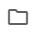을 클릭합니다.
4. Files 탭 바로 아래의 파일 업로드 버튼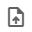을 클릭하고, 다운받은 `music.json`를 선택 후 확인 버튼을 누릅니다.

이를 통해 `music.json`을 인스턴스에 업로드 할 수 있습니다.
이후 아래 코드를 실행하면 fine-tune 및 테스트를 진행할 수 있습니다.


In [1]:
import torch
from tokenizers import SentencePieceBPETokenizer
from transformers import GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast, AdamW
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [3]:
# 2012-2023 melon Top100
with open('./music.json', 'r') as f:
  raw_data = json.load(f)

In [4]:
class MusicDataset(Dataset):
  def __init__(self, tokenizer, raw_data):
    self.ids = []
    for music in raw_data:
      self.bos_token = tokenizer.bos_token
      self.eos_token = tokenizer.eos_token
      tokenized = tokenizer.tokenize(self.bos_token + ' ' + music['lyric'] + ' ' + self.eos_token)
      music_ids = tokenizer(tokenized, return_tensors = "pt", padding = "max_length", truncation=True, max_length = 256)['input_ids']
      self.ids.append(music_ids)

  def __getitem__(self, idx):
    return self.ids[idx]

  def __len__(self):
    return len(self.ids )


In [5]:
# 데이터간의 길이를 일치시키기 위함
class PaddingCollate():
  def __init__(self, pad_id):
    self.pad_id = pad_id

  def pad_collate(self, batch):
    inputs = []
    for seq in batch:
      inputs.append(torch.LongTensor(seq[0]))
    inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first = True, padding_value = self.pad_id)
    return inputs


In [6]:
def MusicDataLoader(tokenizer, raw_data, batch_size, collate):
  data = MusicDataset(tokenizer, raw_data)
  return DataLoader(data, batch_size = batch_size, collate_fn = collate)

In [7]:
EPOCH = 20
LR = 3e-5

In [8]:
train_loader = MusicDataLoader(tokenizer, raw_data, 4, PaddingCollate(tokenizer.pad_token_id).pad_collate)
optimizer = AdamW(model.parameters(), lr =LR)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
for epoch in range(EPOCH):
  print(f'Training epoch {epoch}')
  losses = []
  for music in tqdm(train_loader):
    music = music.to(device)
    # Hugging face의 GPT2LMHeadModel에서 label을 주면 알아서 하나씩 shift해줍니다.
    outputs = model(music, labels=music)
    loss = outputs[0]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  print(f'epoch {epoch}: loss {np.mean(losses)}')

Training epoch 0


100%|██████████| 281/281 [01:23<00:00,  3.37it/s]


epoch 0: loss 0.07379927770347539
Training epoch 1


100%|██████████| 281/281 [01:22<00:00,  3.43it/s]


epoch 1: loss 2.492827846762083e-05
Training epoch 2


100%|██████████| 281/281 [01:22<00:00,  3.43it/s]


epoch 2: loss 1.309571772023747e-05
Training epoch 3


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 3: loss 8.478395338703628e-06
Training epoch 4


100%|██████████| 281/281 [01:22<00:00,  3.43it/s]


epoch 4: loss 5.978048018577448e-06
Training epoch 5


100%|██████████| 281/281 [01:22<00:00,  3.43it/s]


epoch 5: loss 4.724868421074711e-06
Training epoch 6


100%|██████████| 281/281 [01:21<00:00,  3.43it/s]


epoch 6: loss 3.332044723046953e-06
Training epoch 7


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 7: loss 2.689511342998159e-06
Training epoch 8


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 8: loss 2.4522269717590623e-06
Training epoch 9


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 9: loss 2.2971394302975344e-06
Training epoch 10


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 10: loss 2.096702401848693e-06
Training epoch 11


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 11: loss 1.2192230860495444e-06
Training epoch 12


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 12: loss 7.381996066729549e-07
Training epoch 13


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 13: loss 5.382234887367168e-07
Training epoch 14


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 14: loss 4.3992780581730937e-07
Training epoch 15


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 15: loss 3.746187461465492e-07
Training epoch 16


100%|██████████| 281/281 [01:21<00:00,  3.43it/s]


epoch 16: loss 3.2555666223895294e-07
Training epoch 17


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 17: loss 2.890616650999693e-07
Training epoch 18


100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


epoch 18: loss 2.6708021175757907e-07
Training epoch 19


100%|██████████| 281/281 [01:21<00:00,  3.43it/s]

epoch 19: loss 2.5079830692726364e-07


In [15]:
# encode context the generation is conditioned on
def tokenizing(text):
    return torch.tensor(tokenizer.encode(text)).to('cuda').unsqueeze(0)

input_ids = tokenizing("당신은 나의 봄")
print(input_ids)
sample_outputs = model.generate(
    input_ids,
    max_length=50,
    early_stopping=True,
    do_sample=True,
    top_k=30,
    top_p = 0.92,
    temperature=0.7,
    no_repeat_ngram_size=3,
    num_return_sequences = 2,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    use_cache=True
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output.tolist(), skip_special_tokens=True)))

tensor([[ 9162, 12928, 19520, 11294]], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Output:
----------------------------------------------------------------------------------------------------
0: 당신은 나의 봄꽃도피는ath 기도 마니돈oe돌력 기수힘 경마박∼10선인 몽골의
1: 당신은 나의 봄꽃피는athedia 마니ologtooe돈의박돌 참고눌ile박하고축으로
